# Point Spread Function (PSF)

Create a PSF using STARRED [https://gitlab.com/cosmograil/starred] and stars from the drizzled HST data.

In [1]:
import glob
import os
import time
import h5py

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import numpy as np

from astroObjectAnalyser.DataAnalysis.analysis import Analysis

from astropy.io import fits
from astropy.visualization import ImageNormalize, LogStretch
from astropy.table import Table

import matplotlib.colors as colors
import pyregion
from starred.plots import plot_function as pltf

In [ ]:
# get catalog numbers for quasar images and lens
object_name = 'J2325-5229'
filter = 'F814W'

if filter == 'F160W':
    type = 'drz'
else:
    type = 'drc'

cat = fits.open(f'../cutout_data/{object_name}/{filter}/pysex_{object_name}_{filter}.cat')[2]
cat_table = Table(cat.data)
pix_targ = [[2235, 3581], [2240, 3544], [2562, 3521]] # quasar and host position
offset = 50
mask_quasar = (abs(cat_table['X_IMAGE'] - pix_targ[0][0]) < offset) & (abs(cat_table['Y_IMAGE'] - pix_targ[0][1]) < offset)
cat_table[mask_quasar]


NUMBER,FLAGS,X_IMAGE,Y_IMAGE,FLUX_BEST,FLUXERR_BEST,MAG_BEST,MAGERR_BEST,FLUX_RADIUS,CLASS_STAR,A_IMAGE,B_IMAGE,THETA_IMAGE,ELLIPTICITY,X_WORLD,Y_WORLD
int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
3940,2,2236.9053,3544.7341,263.71317,0.7153538,25.57577,0.002945906,17.614437,0.033343736,16.022346,13.678145,-26.18978,0.14630824,351.42170704178807,-52.48757001615088
4310,3,2224.6667,3586.1235,59.038036,0.21841335,27.20077,0.0040176963,1.6849717,0.96927464,3.0841155,2.802005,-7.350078,0.09147209,351.4219303170874,-52.48711012647726
4378,2,2232.6,3606.2302,1.0363549,0.11980229,31.589828,0.12554124,3.8966553,0.49562594,1.4215785,1.308287,28.120607,0.07969415,351.42178553825227,-52.4868867228301
4396,0,2208.7583,3612.8684,0.2164749,0.04100556,33.29008,0.20571455,1.3344914,0.4700665,1.038335,0.63608915,60.616436,0.38739502,351.42222056308594,-52.4868129505315


## PSF reconstruction
### Select stars for PSF extraction

{'MagMaxThresh': np.float64(27.054668807983397), 'MagMinThresh': np.float64(24.07809829711914), 'SizeMinThresh': 0, 'SizeMaxThresh': 0, 'EllipticityThresh': 0.1, 'ClassStarMax': 1.0, 'ClassStarMin': 0.5}
Blended PSF stars excluded.
Check saturation result: no saturation of PSF stars. 
Quasar excluded.
Flags excluded.
Blended PSF stars excluded.
Check saturation result: no saturation of PSF stars. 
Quasar excluded.
Flags excluded.
6 number of stars


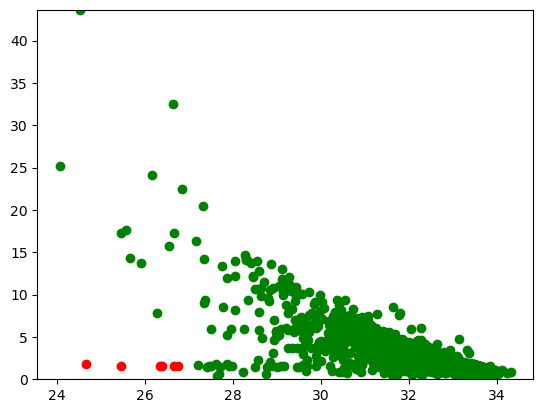

In [ ]:
# identify quasar
cat_quasar_num = [cat.data[mask_quasar]["NUMBER"][0], cat.data[mask_quasar]["NUMBER"][1], cat.data[mask_quasar]["NUMBER"][2]] # from the sextractor catalog

# magnitude-size plot
mag = np.array(cat.data['MAG_BEST'],dtype=float)
mag[mag > 50] = np.mean(mag)
size = np.array(cat.data['FLUX_RADIUS'],dtype=float)

analysis = Analysis()

# select stars
kwargs_cuts = analysis.estimate_star_thresholds(cat)
print(kwargs_cuts)
# kwargs_cuts['ClassStarMin'] = 0.1
kwargs_cuts['EllipticityThresh'] = 0.3
kwargs_cuts['SizeMinThresh'] = 1.0
kwargs_cuts['SizeMaxThresh'] = 7

if filter == 'F160W':
    kwargs_cuts['SizeMaxThresh'] = 3.5


def exclude_blended(mask, cat):
    """exclude blended psf stars

    Args:
        mask (_type_): mask return by astroobject analyzer
        cat (_type_): sextractor catalog

    Returns:
        _type_: updated mask
    """
    flags_mask = cat.data[mask]['FLAGS']
    mask_mask = mask[mask]
    mask_mask = np.where(flags_mask == 3, False, True)
    mask[mask == True] = mask_mask
    print('Blended PSF stars excluded.')
    return mask

def exclude_saturation(mask, cat):
    """exclude saturated psf stars

    Args:
        mask (_type_): _description_
        cat (_type_): _description_

    Returns:
        _type_: _description_
    """
    flags_mask = cat.data[mask]['FLAGS']
    mask_mask = mask[mask]
    flags_all = np.zeros_like(flags_mask)
    for i, flag in enumerate(flags_mask):
        flag_saturation = np.binary_repr(int(flag), 8)[-3]
        if flag_saturation == 1:
            print('Warning: the {i}-th psf star has at least 1 pixel saturated!' .format(i))
            mask_mask[i] = False
    if np.sum(flags_all) == 0:
        print('Check saturation result: no saturation of PSF stars. ')
    mask[mask == True] = mask_mask
    return mask

def exclude_quasar(mask, cat, quasar_num):
    """exclude quasars in PSF stars

    Args:
        mask (_type_): _description_
        cat (_type_): _description_
        quasar_num (_type_): the "NUMBER" id of the quasar in sextractor catalog

    Returns:
        _type_: _description_
    """
    obj_num = cat.data[mask]['NUMBER']
    mask_mask = mask[mask]
    for i, num in enumerate(obj_num):
        if num in quasar_num:
            mask_mask[i] = False
    mask[mask == True] = mask_mask
    print('Quasar excluded.')
    return mask

def exclude_flags(mask, cat):
    """exclude blended psf stars

    Args:
        mask (_type_): mask return by astroobject analyzer
        cat (_type_): sextractor catalog

    Returns:
        _type_: updated mask
    """
    flags_mask = cat.data[mask]['FLAGS']
    mask_mask = mask[mask]
    mask_mask = np.where(flags_mask != 0, False, True)
    mask[mask == True] = mask_mask
    print('Flags excluded.')
    return mask

def exclude_specific(mask, cat, obj_nums):

    obj_num = cat.data[mask]['NUMBER']
    mask_mask = mask[mask]
    for i, num in enumerate(obj_nums):
        if num in obj_num:
            mask_mask[num == obj_num] = False
    mask[mask == True] = mask_mask
    return mask

nums = [30, 161, 855]


kwargs_cuts['MagMaxThresh'] = 27
kwargs_cuts['MagMinThresh'] = 21
mask1 = analysis.find_objects(cat, kwargs_cuts)

mask1 = exclude_blended(mask1, cat) # exclude blended objects (only here)
mask1 = exclude_saturation(mask1, cat)
mask1 = exclude_quasar(mask1, cat, cat_quasar_num)
mask1 = exclude_specific(mask1, cat, nums)
mask1 = exclude_flags(mask1, cat)

kwargs_cuts['MagMinThresh'] = 23
mask2 = analysis.find_objects(cat, kwargs_cuts)

mask2 = exclude_blended(mask2, cat) # exclude blended objects (only here)
mask2 = exclude_saturation(mask2, cat)
mask2 = exclude_quasar(mask2, cat, cat_quasar_num)
mask2 = exclude_specific(mask2, cat, nums)
mask2 = exclude_flags(mask2, cat)

mask = np.logical_or(mask1, mask2)

print(np.sum(mask), 'number of stars')
plt.plot(mag[mask > 0], size[mask > 0], 'or')
plt.plot(mag[mask == 0], size[mask == 0], 'og')
plt.ylim([0, np.max(size)])
plt.show()

In [5]:
cat_table[mask] 

NUMBER,FLAGS,X_IMAGE,Y_IMAGE,FLUX_BEST,FLUXERR_BEST,MAG_BEST,MAGERR_BEST,FLUX_RADIUS,CLASS_STAR,A_IMAGE,B_IMAGE,THETA_IMAGE,ELLIPTICITY,X_WORLD,Y_WORLD
int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
485,0,2184.522,995.12787,123.122345,0.25443467,26.402758,0.0022442397,1.5691957,0.97191197,2.4383476,2.4150116,29.359974,0.00957036,351.42266588086835,-52.51589894012191
706,0,2445.3032,1176.4858,97.56146,0.22887665,26.655403,0.0025477277,1.5934427,0.9703807,2.4209774,2.3017368,-70.583534,0.049253047,351.41790438651935,-52.513883943394944
893,0,4654.292,1404.6528,606.05,0.54423565,24.672329,0.0009752329,1.7529458,0.9734262,3.306665,3.214567,73.020805,0.027852237,351.37757553012443,-52.51134187212199
977,0,1379.0482,1391.019,89.06523,0.22026072,26.754328,0.0026857073,1.5265219,0.9768217,2.3878896,2.3103557,-31.966236,0.03246963,351.4373707646937,-52.51149865905283
2731,0,3816.6833,2553.3977,295.50635,0.3842737,25.452183,0.0014122243,1.6162072,0.97313875,2.887012,2.6935883,-51.03409,0.066997886,351.39287480129514,-52.49858226408773
5397,0,1398.0283,4227.8423,128.42729,0.25956675,26.356956,0.0021949345,1.5689025,0.9801899,2.5235548,2.3744373,-40.21458,0.059090257,351.4370106108094,-52.479978458796964


### make PSF star cutouts

In [6]:
from astroObjectAnalyser.astro_object_superclass import StrongLensSystem

def InitiateSystem(name, filter, ra, dec, ra_cutout_cent=None, dec_cutout_cent=None):
    """initialize a Strong Lens System with relevant image and weight data"""

    # define the folder containing reduced data
    reduced_data_folder = '../../reduced_data'
    # path to the reduced data for the specified name and filter
    path2reduced_data = f'{reduced_data_folder}/{name}_reduced/{filter}'
    
    # create an instance of StrongLensSystem
    system = StrongLensSystem(name)
    
    # determine file names based on the filter type
    if filter == 'F160W':
        img_file = f'{name}_{filter}_drz_sci.fits'  # science image file for F160W
        wht_file = f'{name}_{filter}_drz_wht.fits'  # weight file for F160W
    else:
        img_file = f'{name}_{filter}_drc_sci.fits'  # science image file for other filters
        wht_file = f'{name}_{filter}_drc_wht.fits'  # weight file for other filters
    
    # full paths to image and weight data
    path2img_data = os.path.join(path2reduced_data, img_file)
    path2wht_data = os.path.join(path2reduced_data, wht_file)
    
    # set cutout center coordinates if not provided
    if ra_cutout_cent is None:
        ra_cutout_cent = ra
    if dec_cutout_cent is None:
        dec_cutout_cent = dec
    
    # add image data to the system instance with cutout and other parameters
    system.add_image_data_init(filter, path2img_data, local_wht_filename=path2wht_data, 
                               cutout_scale=100, data_type='HST_new', 
                               ra=ra, dec=dec, 
                               ra_cutout_cent=ra_cutout_cent, dec_cutout_cent=dec_cutout_cent)
    return system

if filter == 'F160W':
    type = 'drz'
else:
    type = 'drc'

rerun_preprocess = True

# get ra and dec from image
with fits.open(f'../../reduced_data/{object_name}_reduced/{filter}/{object_name}_{filter}_{type}_sci.fits') as hdu:
    sci_header = hdu[0].header
    ra_targ = sci_header['ra_targ']
    dec_targ = sci_header['dec_targ']

ccd gain = 1.5
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex ../../reduced_data/J2325-5229_reduced/F814W/J2325-5229_F814W_drc_sci.fits  -c .pysex.sex -GAIN 2142.0 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- SExtractor 2.28.2 started on 2025-09-03 at 16:04:45 with 20 threads

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for J2325-5229_F814W_drc_sci.fits
----- Measuring from: J2325-5229_F814W_drc_sci.fits [0/2]
      "Unnamed" / no ext. header / 4880x5080 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map 

separate exposure map loaded


/tmp/ipykernel_2709037/3202188524.py:26: RuntimeWarning: invalid value encountered in arccosh
  norm = ImageNormalize(np.arccosh(star_imgs[i]), vmin = 0., vmax = 25, stretch=LogStretch())


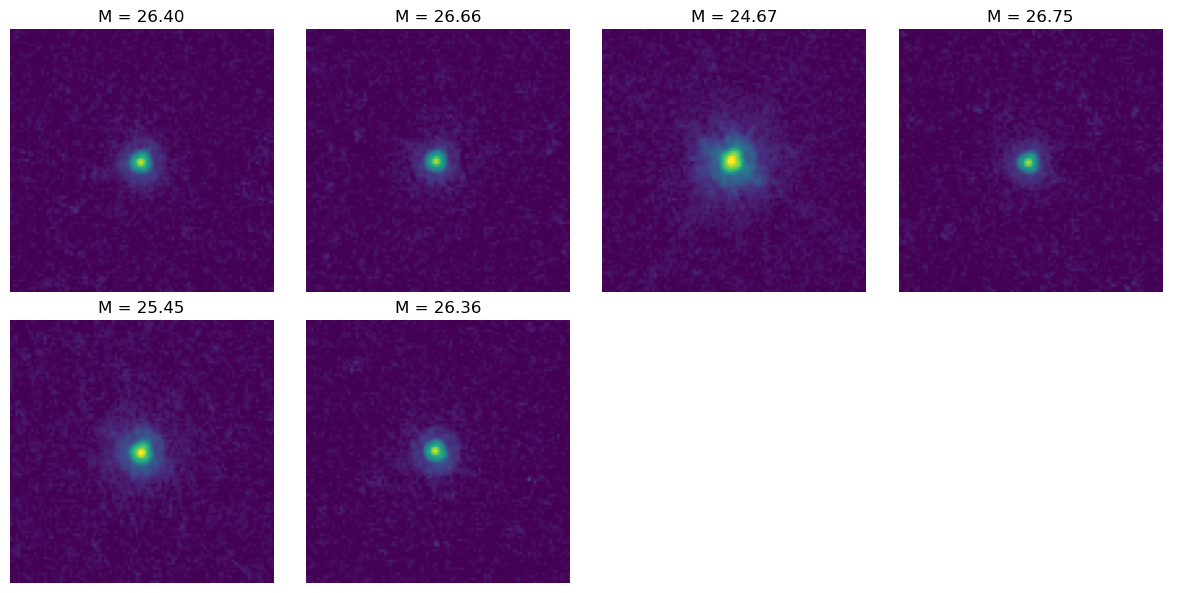

In [7]:
system = InitiateSystem(object_name, filter, ra_targ, dec_targ)
mean_bkd, sigma_bkd = system.get_background(filter)

img_full = system.get_full_image(filter) # get the full image
star_imgs= analysis.get_objects_image(img_full - mean_bkd, cat, mask, 50) # get star cutouts, background subtracted

wht_full = system.get_full_exposure(filter) # get the full exposure map
wht_full[wht_full <= 0] = 10**(-10)
star_whts = analysis.get_objects_image(wht_full, cat, mask, 50) # get exposure map cutouts for stars

# convert the cutouts into units of e-
# exp_time = system.get_exposure_time(filter)
# print(exp_time)
# star_imgs  = [star_img * exp_time for star_img in star_imgs]

# plot star cutouts
num_stars = len(mask.nonzero()[0])
ncols = 4 
nrows = (num_stars + ncols - 1) // ncols  # calculate number of rows needed

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
ax = ax.flatten()  # flatten the axes array for easy indexing

for i in range(num_stars):
    # display cutout image
    norm = ImageNormalize(np.arccosh(star_imgs[i]), vmin = 0., vmax = 25, stretch=LogStretch())
    ax[i].imshow(star_imgs[i], norm=norm, cmap='viridis', origin='lower')
    # ax[i].imshow(np.log10(star_whts[i]), cmap='viridis', origin='lower')
    ax[i].set_title('M = {:.2f}' .format(cat_table[mask][i]['MAG_BEST'])) 
    ax[i].axis('off') 

# hide any remaining unused subplots
for j in range(num_stars, nrows * ncols):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

# save star cutouts
# star_cutouts_all = np.array([x.flatten() for x in star_imgs])
# save the star cutouts to desired location
# np.save('./star_cutouts.npy', star_cutouts_all)

### make noise maps

/tmp/ipykernel_2709037/2354038323.py:19: RuntimeWarning: invalid value encountered in arccosh
  norm = ImageNormalize(np.arccosh(star_imgs[i]), vmin=-0.2, vmax=25, stretch=LogStretch())


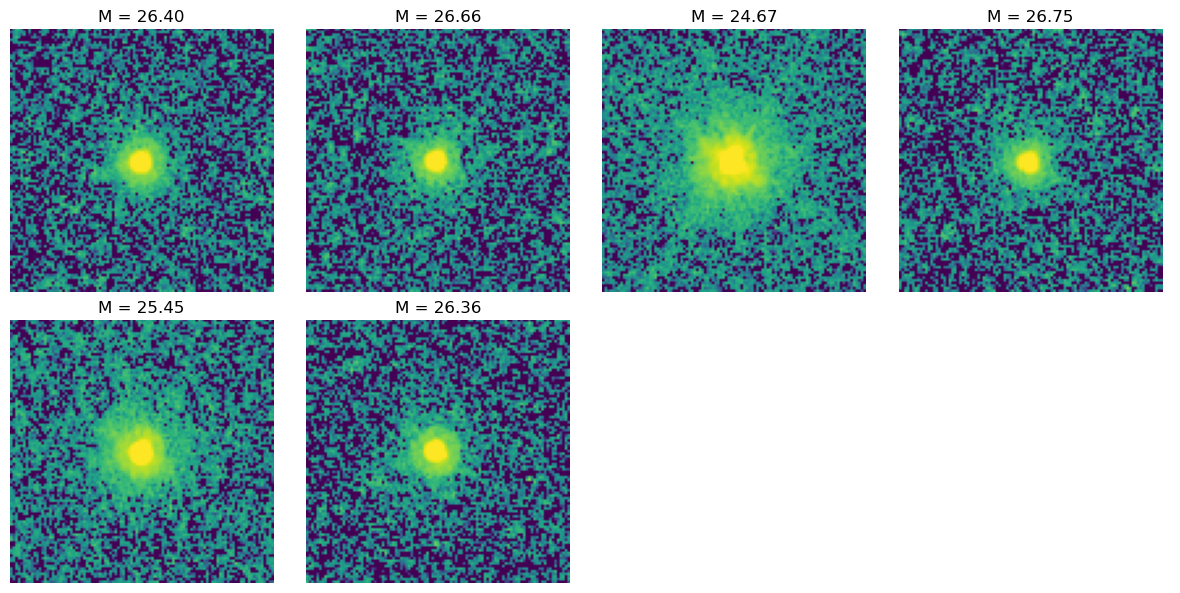

In [8]:
# generate input for STARRED
# make noise map
noise_maps = []
for i, star_img in enumerate(star_imgs):
    nx_im, ny_im = np.shape(star_img)
    noise_map_2 = np.abs(star_img) / star_whts[i] + sigma_bkd**2
    noise_maps.append(np.sqrt(noise_map_2))

# plot star cutouts
num_stars = len(mask.nonzero()[0])
ncols = 4 
nrows = (num_stars + ncols - 1) // ncols  # calculate number of rows needed

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
ax = ax.flatten()  # flatten the axes array for easy indexing

for i in range(num_stars):
    # display cutout image
    norm = ImageNormalize(np.arccosh(star_imgs[i]), vmin=-0.2, vmax=25, stretch=LogStretch())
    ax[i].imshow(star_imgs[i] / noise_maps[i], norm=norm, cmap='viridis', origin='lower')
    # ax[i].imshow(noise_maps[i], cmap='viridis', origin='lower', norm=norm)
    ax[i].set_title('M = {:.2f}' .format(cat_table[mask][i]['MAG_BEST'])) 
    ax[i].axis('off') 

# hide any remaining unused subplots
for j in range(num_stars, nrows * ncols):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

### setup working directory

In [9]:
test_dir = './psf_estimate/{}/{}' .format(filter, object_name)

if not os.path.isdir(test_dir):
    os.makedirs(test_dir)

star_dir = os.path.join(test_dir, 'stars')
noise_dir = os.path.join(test_dir, 'noise_maps')

if not os.path.isdir(star_dir):
    os.makedirs(star_dir)
if not os.path.isdir(noise_dir):
    os.makedirs(noise_dir) 

In [10]:
save_star_cutout = True

if save_star_cutout:

    if os.path.isdir(star_dir):
        file_temp = glob.glob(os.path.join(star_dir, 'star*.fits')) # if star cutout fits files exist, first remove them 
        for file in file_temp:
            os.remove(file)
    else:
        os.makedirs(star_dir)

    if os.path.isdir(noise_dir):
        file_temp = glob.glob(os.path.join(noise_dir, 'noise_map_*.fits')) # if noise map cutout fits files exist, first remove them 
        for file in file_temp:
            os.remove(file)
    else:
        os.makedirs(noise_dir) 
    
    for i in range(len(star_imgs)):
        hdu = fits.PrimaryHDU(star_imgs[i])
        hdul = fits.HDUList([hdu])
        hdul.writeto(os.path.join(star_dir, 'star_%i.fits'%(i)), overwrite=True)

        hdu = fits.PrimaryHDU(noise_maps[i])
        hdul = fits.HDUList([hdu])
        hdul.writeto(os.path.join(noise_dir, 'noise_map_%i.fits'%(i)), overwrite=True)

### STARRED PSF reconstruction

From the starred example notebook.

In [11]:
data_dim = star_imgs[0].shape[0]
masks = np.ones((len(star_imgs), data_dim, data_dim))
for i in range(len(star_imgs)):
    possiblemaskfilepath = os.path.join(noise_dir, 'mask_%s.reg'%str(i))
    if os.path.exists(possiblemaskfilepath):
        print('Using mask %s for star %i !'%(possiblemaskfilepath, i))
        r = pyregion.open(possiblemaskfilepath)
        masks[i, :, :] =  1 - r.get_mask(shape=(data_dim, data_dim)).astype(float)

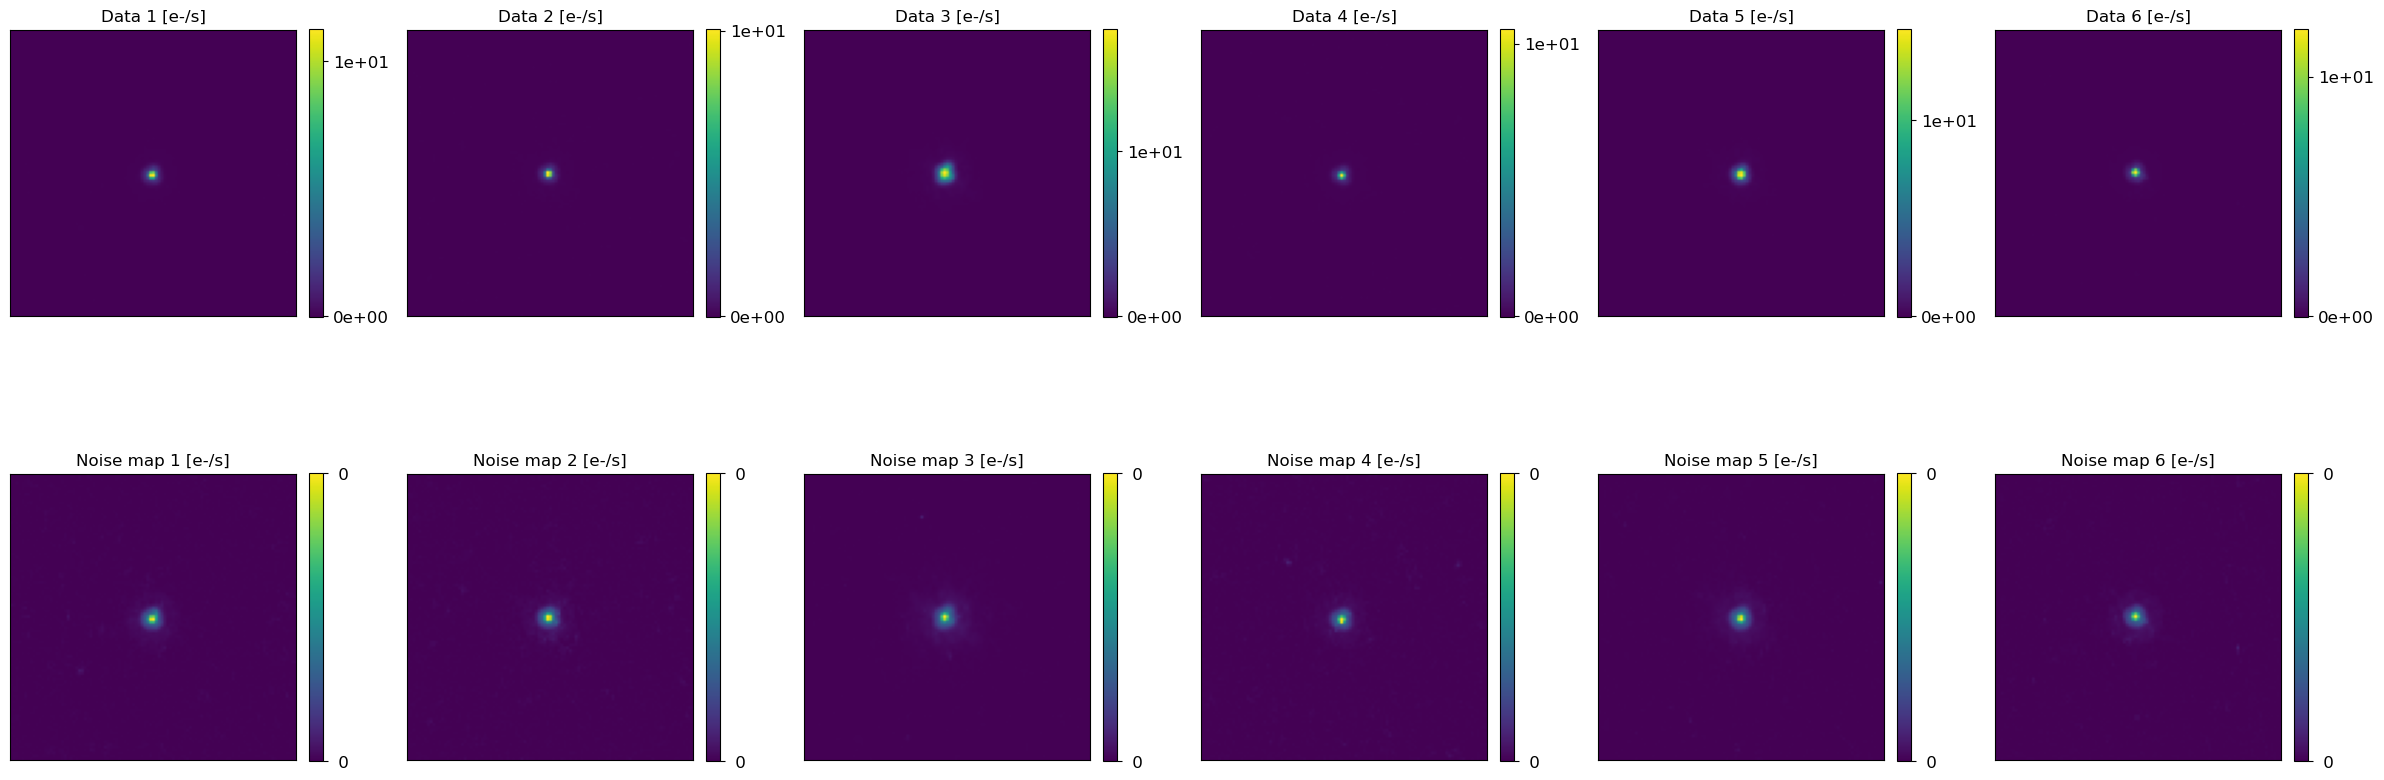

In [12]:
star_imgs_array = np.array(star_imgs)
noise_maps_array = np.array(noise_maps)

fig = pltf.display_data(star_imgs_array, sigma_2=noise_maps_array**2, masks=None, units='e-/s')

In [13]:
rerun_starred = True

if rerun_starred:

    lambda_scale = 2.
    lambda_hf = 2.
    niter = 1000
    subsampling = 3
    learning_rate = 1e-2
    noise_method = 'MC'

    file_to_run = '1_generate_psf.py'

    outputpath = os.path.abspath(os.path.join(test_dir, 'outputs'))

    if not os.path.isdir(outputpath):
        os.makedirs(outputpath)

    argument = '--data-path %s --output-path %s '%(star_dir,outputpath)
    argument += '--lambda-scales %2.2e '%lambda_scale
    argument += '--lambda-hf %2.2e '%lambda_hf
    argument += '--niter %i '%niter
    argument += '--subsampling-factor %i '%subsampling
    argument += '--noise-map-path %s '%noise_dir
    argument += '--method-noise %s '%noise_method
    argument += '--float64 '
    argument += '--init-learning-rate %2.2e '%learning_rate
    argument += '--optim-analytical Newton-CG '
    argument += '--use-masks'

    start_time = time.time()
    cmd = 'python3 %s %s'%(file_to_run, argument)
    print(cmd)
    os.system('python3 %s %s'%(file_to_run, argument))
    print('Running in %2.2f seconds'%(time.time() - start_time))

python3 1_generate_psf.py --data-path ./psf_estimate/F814W/J2325-5229/stars --output-path /home/rmbrady/hst_doubles/analysis/psf_estimate/F814W/J2325-5229/outputs --lambda-scales 2.00e+00 --lambda-hf 2.00e+00 --niter 1000 --subsampling-factor 3 --noise-map-path ./psf_estimate/F814W/J2325-5229/noise_maps --method-noise MC --float64 --init-learning-rate 1.00e-02 --optim-analytical Newton-CG --use-masks
Enabling float64 computations.
Running joined fit on 6 images...
Found 6 noise maps...
Initial guess : {'kwargs_moffat': {'fwhm': 3.0, 'beta': 2.0, 'C': 106.2146182731544}, 'kwargs_gaussian': {'a': Array([ 59.11882592,  48.552263  , 282.73046853,  44.11735172,
       142.62681496,  60.14199817], dtype=float64), 'x0': array([-0.33450699, -0.68451309, -0.69676208, -0.35100174, -0.32996368,
       -1.10791397]), 'y0': array([-1.24549103, -0.3818512 , -0.31163025, -0.95926285, -0.34024429,
       -0.02777481])}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=flo

/home/rmbrady/miniconda3/envs/dolphin/lib/python3.12/site-packages/starred/optim/optimization.py:78: UserWarning: You are using an unconstrained optimiser. Bounds are ignored.
  warnings.warn('You are using an unconstrained optimiser. Bounds are ignored.')


Success of the step 1 fit in 43 iterations (46.58239006996155 s)


/home/rmbrady/miniconda3/envs/dolphin/lib/python3.12/site-packages/starred/utils/noise_utils.py:53: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


Step 1/2 took 47 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm': Array([1.75627484], dtype=float64), 'beta': Array([1.75337116], dtype=float64), 'C': Array([106.21461825], dtype=float64)}, 'kwargs_gaussian': {'a': Array([139.98695663, 111.48928893, 638.33072714, 100.28331124,
       321.47918061, 141.17375038], dtype=float64), 'x0': Array([-0.43276869, -0.6763159 , -0.85475896, -0.94549533, -0.25164347,
       -1.00612938], dtype=float64), 'y0': Array([-0.86208746, -0.44498473, -0.2761249 , -0.99089009, -0.63870517,
       -0.00245578], dtype=float64)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'mean': Array([0., 0., 0., 0., 0., 0.], dtype=float64)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float64), 'dilation_y': Array([0., 0.], dtype=float64), 'shear': Array([0., 0.], dtype=float64)}}
LogL :  77528.47803014032
Overall Reduced Chi2 :  2.5333620243159274
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 1000/1000 [00:43<00:00, 22.75it/s]


Step 2/2 took 45 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm': Array([1.75627484], dtype=float64), 'beta': Array([1.75337116], dtype=float64), 'C': Array([106.21461825], dtype=float64)}, 'kwargs_gaussian': {'a': Array([142.07253025, 113.20323071, 680.44046969, 102.61475969,
       337.95179777, 146.38726771], dtype=float64), 'x0': Array([-0.43160216, -0.65496003, -0.84202156, -0.92849236, -0.25628361,
       -1.00322508], dtype=float64), 'y0': Array([-0.85255472, -0.44094863, -0.26615524, -0.996003  , -0.62771771,
        0.00127702], dtype=float64)}, 'kwargs_background': {'background': Array([ 0.00190319, -0.00018543, -0.0010996 , ..., -0.00083831,
       -0.00207359,  0.00347246], dtype=float64), 'mean': Array([0., 0., 0., 0., 0., 0.], dtype=float64)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float64), 'dilation_y': Array([0., 0.], dtype=float64), 'shear': Array([0., 0.], dtype=float64)}}
LogL :  38433.0106036987
Overall Reduced Chi2 :  1.044525015362

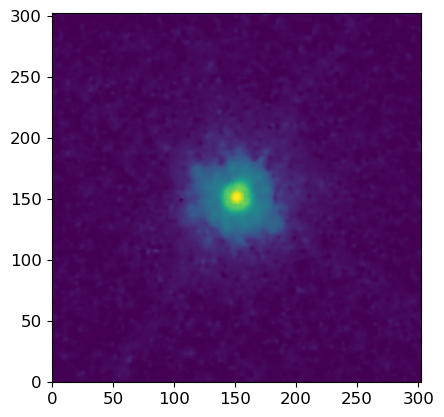

In [14]:
outputpath = os.path.abspath(os.path.join(test_dir, 'outputs'))
PSF_retrieved = fits.open(outputpath+ '/full_PSF.fits')[0].data
plt.imshow(PSF_retrieved, norm=colors.SymLogNorm(linthresh=0.00001, vmin=0, vmax=0.01), origin='lower')

/tmp/ipykernel_2709037/3104693433.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(PSF_retrieved))


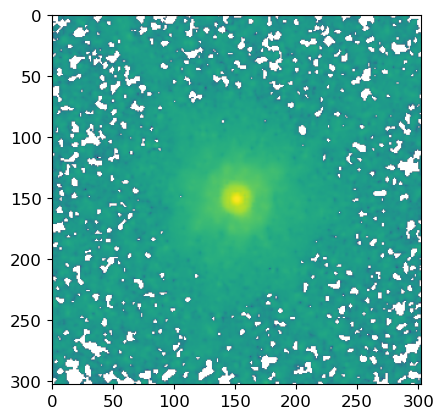

In [15]:
plt.imshow(np.log10(PSF_retrieved))